In [1]:
import os
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sys
sys.path.append('/home/yuanyuan.fu/bin/scripts') 
import plot_spatial_histograms as histplot
from scalebar_util import add_scalebar

root_directory = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/spatial'
os.chdir(root_directory)

/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/

In [2]:
adata_human = sc.read_h5ad(root_directory + "/hmba_release_format_human_cirro_h5ad_20250624.h5ad")
adata_human

AnnData object with n_obs × n_vars = 6992128 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15',

### show the anatomical structure

In [3]:
region_cols = ['STR', 'GPe', 'GPi', 'VP', 'SN', 'STH']

# Create the new 'anatomical_structure' column
def assign_region(row):
    for region in region_cols:
        if row[region]:
            return region
    return 'adjacent'

adata_human.obs['anatomical_structure'] = adata_human.obs.apply(assign_region, axis=1)
adata_human.obs['anatomical_structure'].value_counts()

anatomical_structure
STR         3322914
adjacent    3065314
GPe          342864
SN            90966
GPi           89045
VP            43161
STH           37864
Name: count, dtype: int64

In [4]:
adata_human_structure = adata_human[adata_human.obs['qc_pass']].copy() 

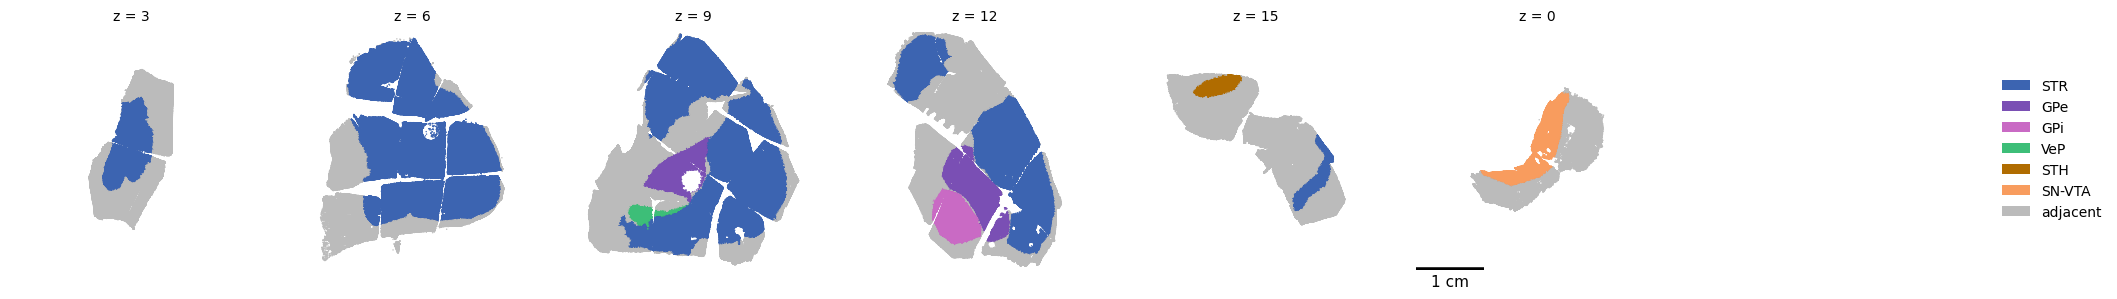

In [5]:
from matplotlib.patches import Patch

# Region mapping
anatomical_to_color_key = {
    'STR': 'STR',
    'GPe': 'GPe',
    'GPi': 'GPi',
    'VP': 'VeP',
    'SN': 'SN-VTA',
    'STH': 'STH',
    'adjacent': 'adjacent'
}
region_color_map = {
    "STR": "#3C64B1", 
    "GPe": "#7A4FB4", 
    "GPi": "#C96AC4",
    "SN-VTA": "#F89C5E", 
    "STH": "#B06C00",
    "VeP": "#3DBE78", 
    "adjacent": "#BBBBBB"
}
ordered_color_keys = ['STR', 'GPe', 'GPi', 'VeP', 'STH', 'SN-VTA', 'adjacent']
selected_sections = [3, 6, 9, 12, 15, 0]

# Define fixed spatial canvas size (in µm)
plot_size_um = 300 * 120  # 36000 µm
half_size = plot_size_um / 2

# Create subplots
fig, axes = plt.subplots(1, len(selected_sections), figsize=(20, 3), sharex=True, sharey=True)
if len(selected_sections) == 1:
    axes = [axes]

for ax, z in zip(axes, selected_sections):
    adata_subset = adata_human_structure[adata_human_structure.obs['z_order'] == z].copy()

    # Assign region colors
    adata_subset.obs['region_color_key'] = adata_subset.obs['anatomical_structure'].map(anatomical_to_color_key)
    adata_subset.obs['region_color_key'] = pd.Categorical(
        adata_subset.obs['region_color_key'],
        categories=ordered_color_keys,
        ordered=True
    )

    # Get spatial coordinates
    coords = adata_subset.obsm['spatial_grid']
    colors = adata_subset.obs['region_color_key'].map(region_color_map)

    # Compute bounding box center for consistent alignment
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    center = np.array([center_x, center_y])

    # Shift to center of fixed-size canvas
    shifted_coords = coords - center + half_size

    # Plot
    ax.scatter(
        shifted_coords[:, 0],
        shifted_coords[:, 1],
        c=colors,
        s=1,
        linewidth=0,
        rasterized=True
    )
    ax.set_xlim(0, plot_size_um)
    ax.set_ylim(0, plot_size_um)
    ax.set_title(f'z = {z}', fontsize=10)
    ax.set_aspect('equal')
    ax.axis('off')

# Legend
legend_elements = [Patch(facecolor=region_color_map[k], label=k) for k in ordered_color_keys]
fig.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0,
    frameon=False
)

# Add scalebar
add_scalebar(
    axes[-1],
    matchx=False,
    matchy=False,
    hidex=True,
    hidey=True,
    loc='lower middle',
    fontsize=11,
    barcolor='black',
    barwidth=4,
    offset=(0.0, 0.0),
    sizex=10000,
    labelx='1 cm'
)

# Save and display
output_dir = root_directory + '/results/figures_astro_enrichment'
os.makedirs(output_dir, exist_ok=True)

fig.savefig(
    f"{output_dir}/anatomical_structure_onlyATLASreleaseplot.png",
    dpi=300,
    bbox_inches='tight'
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, right=0.85)
plt.show()


### Enrichment distribution of Human BG Astrocyte

#### cluster level

In [6]:
adata_human_astro = adata_human[
    (adata_human.obs['Group'] == 'Astrocyte') &
    (adata_human.obs['qc_pass']) # & (adata_human.obs['abc_atlas_release']) # to keep adjacent regions    
].copy()


selected_sections = [3, 6, 9, 12, 15, 0]
adata_human_astro = adata_human_astro[adata_human_astro.obs['z_order'].isin(selected_sections)].copy()
adata_human_astro

AnnData object with n_obs × n_vars = 198386 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15', 

In [7]:
desired_Cluster_order = ['Human-14', 'Human-7', 'Human-31', #GM STR
                         'Human-160', 'Human-450', 'Human-149', # GM exSTR
                         'Human-159', 'Human-145', 'Human-152', 'Human-146', 'Human-452', 'Human-150', 
                         'Human-479', 'Human-485', 'Human-472', 'Human-230', 'Human-28', 'Human-231', 'Human-227', #wm
                         'Human-143', 'Human-232' #mixed
                        ]
adata_human_astro.obs['Cluster'] = pd.Categorical(adata_human_astro.obs['Cluster'], categories=desired_Cluster_order, ordered=True)

print(adata_human_astro.obs['Cluster'].cat.categories)
print(adata_human_astro.obs['Cluster'].dtype)

Index(['Human-14', 'Human-7', 'Human-31', 'Human-160', 'Human-450',
       'Human-149', 'Human-159', 'Human-145', 'Human-152', 'Human-146',
       'Human-452', 'Human-150', 'Human-479', 'Human-485', 'Human-472',
       'Human-230', 'Human-28', 'Human-231', 'Human-227', 'Human-143',
       'Human-232'],
      dtype='object')
category


In [8]:
# Calculate the overal proportion of astrocytes that belong to each astrocyte cluster
astro_cluster_proportions_global = adata_human_astro.obs.groupby('Cluster', observed=True).size() / adata_human_astro.shape[0]
astro_cluster_proportions_global = astro_cluster_proportions_global.to_dict()
astro_cluster_proportions_global

{'Human-14': 0.2522909882753823,
 'Human-7': 0.15973405381428124,
 'Human-31': 0.07052917040516972,
 'Human-160': 0.06740899055376892,
 'Human-450': 0.02710876775578922,
 'Human-149': 0.015333743308499593,
 'Human-159': 0.01871099775185749,
 'Human-145': 0.020384502938715434,
 'Human-152': 0.007530773340860746,
 'Human-146': 0.003830915487988064,
 'Human-452': 0.0018096035002469933,
 'Human-150': 0.004365227384996925,
 'Human-479': 0.08443136108394746,
 'Human-485': 0.017486112931356042,
 'Human-472': 0.025500791386488968,
 'Human-230': 0.020712147026503886,
 'Human-28': 0.07260088917564747,
 'Human-231': 0.06543808534876452,
 'Human-227': 0.0009073220892603309,
 'Human-143': 0.007142641113788271,
 'Human-232': 0.056742915326686356}

In [9]:
plt.close('all')
obs_field = 'Cluster'

z_orders = [3, 6, 9, 12, 15, 0]
n_z = len(z_orders)
ncols = 7
nrows = int(np.ceil(n_z / ncols))
figsize_per_row = 4
figsize = (ncols * 3, nrows * figsize_per_row)  # 

for cat in adata_human_astro.obs[obs_field].cat.categories:
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    used_axes = []

    for i, sec in enumerate(z_orders):
        adata_sec = adata_human_astro[adata_human_astro.obs['z_order'] == sec].copy()
        ax = axes[i]
        used_axes.append(i)

        _ = histplot.make_2D_hist_enrichment_log2(
            adata_sec, 
            obs_field=obs_field, 
            category=cat,
            coords_obsm_key='spatial_grid',
            binsize=300,
            imshow_size=300*120,
            global_propor_dict=astro_cluster_proportions_global,
            vlims=(-4,4),
            cmap='PiYG_r',
            no_cells_color="#ebebeb", #"#d3d3d3",
            no_category_color="black",
            show_colorbar=False,  # 
            ax=ax,
        )
        ax.set_title(f'z={sec}', fontsize=10)

    # delete unusable ax
    for j, ax in enumerate(axes):
        if j not in used_axes:
            fig.delaxes(ax)

    # add scale bar
    add_scalebar(
        axes[used_axes[-1]],   # last subplot
        matchx=False,
        matchy=False,
        hidex=True,
        hidey=True,
        loc='lower middle',
        fontsize=11,
        barcolor='black',
        barwidth=4,
        offset=(0.0, 0.0),
        sizex=10000,        # 5000 um
        labelx='1 cm'
    )

    # add sharing colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=-4, vmax=4)
    sm = plt.cm.ScalarMappable(cmap='PiYG_r', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('log2(enrichment)', fontsize=12)

    fig.suptitle(f'Cluster = {cat}', fontsize=14)
    plt.subplots_adjust(hspace=0.02, wspace=0.04, right=0.9)
    
    os.makedirs(root_directory + '/results/figures_astro_enrichment', exist_ok=True)
    fig.savefig(
        root_directory + f'/results/figures_astro_enrichment/astrocyte_histogram_enrichment_log2_{obs_field}_{cat}.png', 
        dpi=300,
        bbox_inches='tight',
    )
    plt.close(fig)


#### subGroup level

In [10]:
Cluster_to_subGroup = {
    "Human-14": "GM STR",
    "Human-7": "GM STR",
    "Human-31": "GM STR",
    "Human-160": "GM exSTR",
    "Human-146": "GM exSTR",
    "Human-149": "GM exSTR",
    "Human-450": "GM exSTR",
    "Human-159": "GM exSTR",
    "Human-150": "GM exSTR",
    "Human-145": "GM exSTR",
    "Human-452": "GM exSTR",
    "Human-152": "GM exSTR",
    "Human-28": "WM",
    "Human-231": "WM",
    "Human-479": "WM",
    "Human-472": "WM",
    "Human-230": "WM",
    "Human-485": "WM",
    "Human-227": "WM",
    "Human-143": "mixed",
    "Human-232": "mixed",
}

adata_human_astro.obs["subGroup"] = adata_human_astro.obs["Cluster"].copy()
adata_human_astro.obs["subGroup"] = adata_human_astro.obs["Cluster"].map(Cluster_to_subGroup)


In [11]:
adata_human_astro_c19 = adata_human_astro[~adata_human_astro.obs['subGroup'].isin(['mixed'])].copy()

desired_subGroup_order = ['GM STR', 'GM exSTR', 'WM']
adata_human_astro_c19.obs['subGroup'] = pd.Categorical(adata_human_astro_c19.obs['subGroup'], categories=desired_subGroup_order, ordered=True)
adata_human_astro_c19

AnnData object with n_obs × n_vars = 185712 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15', 

In [12]:
# Calculate the overal proportion of astrocytes that belong to each astrocyte cluster
astro_subGroup_proportions_global = adata_human_astro_c19.obs.groupby('subGroup', observed=True).size() / adata_human_astro_c19.shape[0]
astro_subGroup_proportions_global = astro_subGroup_proportions_global.to_dict()
astro_subGroup_proportions_global

{'GM STR': 0.5154863444473162,
 'GM exSTR': 0.17784526578788662,
 'WM': 0.3066683897647971}

In [13]:
plt.close('all')
obs_field = 'subGroup'

z_orders = [3, 6, 9, 12, 15, 0]
n_z = len(z_orders)
ncols = 7
nrows = int(np.ceil(n_z / ncols))
figsize_per_row = 4
figsize = (ncols * 3, nrows * figsize_per_row)  # 

for cat in adata_human_astro_c19.obs[obs_field].cat.categories:
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    used_axes = []

    for i, sec in enumerate(z_orders):
        adata_sec = adata_human_astro_c19[adata_human_astro_c19.obs['z_order'] == sec].copy()
        ax = axes[i]
        used_axes.append(i)

        _ = histplot.make_2D_hist_enrichment_log2(
            adata_sec, 
            obs_field=obs_field, 
            category=cat,
            coords_obsm_key='spatial_grid',
            binsize=300,
            imshow_size=300*120,
            global_propor_dict=astro_subGroup_proportions_global,
            vlims=(-4,4),
            cmap='PiYG_r',
            no_cells_color="#ebebeb", #f5f5f5"
            no_category_color="black",
            show_colorbar=False,  # 
            ax=ax,
        )
        ax.set_title(f'z={sec}', fontsize=10)

    # delete unusable ax
    for j, ax in enumerate(axes):
        if j not in used_axes:
            fig.delaxes(ax)
    
    # add scalebar 
    add_scalebar(
        axes[used_axes[-1]],
        matchx=False,
        matchy=False,
        hidex=True,
        hidey=True,
        loc='lower middle',
        fontsize=11,
        barcolor='black',
        barwidth=4,
        offset=(0.0, 0.0),  
        sizex=10000,
        labelx='1 cm'
    )

    # add shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=-4, vmax=4)
    sm = plt.cm.ScalarMappable(cmap='PiYG_r', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('log2(enrichment)', fontsize=12)

    fig.suptitle(f'Cluster = {cat}', fontsize=14)
    plt.subplots_adjust(hspace=0.02, wspace=0.04, right=0.9)
    
    os.makedirs(root_directory + '/results/figures_astro_enrichment', exist_ok=True)
    fig.savefig(
        root_directory + f'/results/figures_astro_enrichment/astrocyte_histogram_enrichment_log2_{obs_field}_{cat}.png', 
        dpi=300,
        bbox_inches='tight',
    )
    plt.close(fig)
